In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import tensorflow as tf
from collections import Counter
from tqdm import tqdm
from PIL import Image
import time
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imutils import paths
from skimage.metrics import structural_similarity as ssim
# TensorFlow for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Torch for feature extraction (if used later)
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# Sklearn for modeling and reduction
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score

In [2]:

# Lists to store full images, cropped center images, and labels
full_images = []          # 300x300 grayscale images
cropped_images = []       # 60x60 cropped center patches
image_labels = []         # Class labels as integers
class_names = []          # Class folder names (FR0, FRI, FRII)


In [3]:
# 4. LOAD DATASET
# ----------------------------------
dataset_path = r'C:\Users\ZAIGHI\Downloads\Compressed\radio_morphology_project\Dataset'  # Modify if running locally

for label, folder in enumerate(sorted(os.listdir(dataset_path))):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue

    class_names.append(folder)
    image_paths = list(paths.list_images(folder_path))

    for image_path in image_paths:
        try:
            img = Image.open(image_path).convert("L")  # grayscale
            img_resized = img.resize((300, 300))
            img_cropped = img_resized.crop((120, 120, 180, 180))

            full_images.append(np.array(img_resized))
            cropped_images.append(np.array(img_cropped))
            image_labels.append(label)
        except Exception as e:
            print(f"Skipped {image_path}: {e}")

print(f"Loaded {len(full_images)} images from {len(class_names)} classes: {class_names}")

Loaded 13140 images from 3 classes: ['FR0', 'FRI', 'FRII']


In [4]:
# 5. FILTER LOW-CONTENT IMAGES
# ----------------------------------
# Remove images where the max pixel value is very low (likely black/blank)
valid_mask = np.array([np.max(img) >= 5 for img in cropped_images])

filtered_data = np.array(cropped_images)[valid_mask]
filtered_labels = np.array(image_labels)[valid_mask]

useless_data = np.array(cropped_images)[~valid_mask]
useless_labels = np.array(image_labels)[~valid_mask]

print(f"Filtered dataset: {len(filtered_data)} images retained")
print(f"Discarded (useless) images: {len(useless_data)}")

Filtered dataset: 12970 images retained
Discarded (useless) images: 170


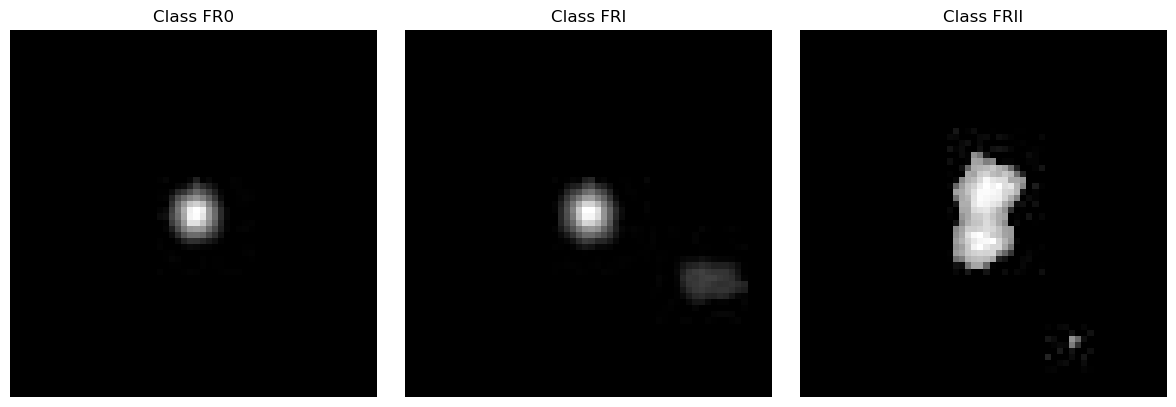

In [5]:
# 6. VISUALIZE FILTERED SAMPLE IMAGES
# ----------------------------------
plt.figure(figsize=(12, 4))
for idx, class_id in enumerate([0, 1, 2]):
    class_samples = filtered_data[filtered_labels == class_id]
    if len(class_samples) > 1:
        img = np.squeeze(class_samples[1])
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {class_names[class_id]}")
        plt.axis('off')
plt.tight_layout()
plt.show()

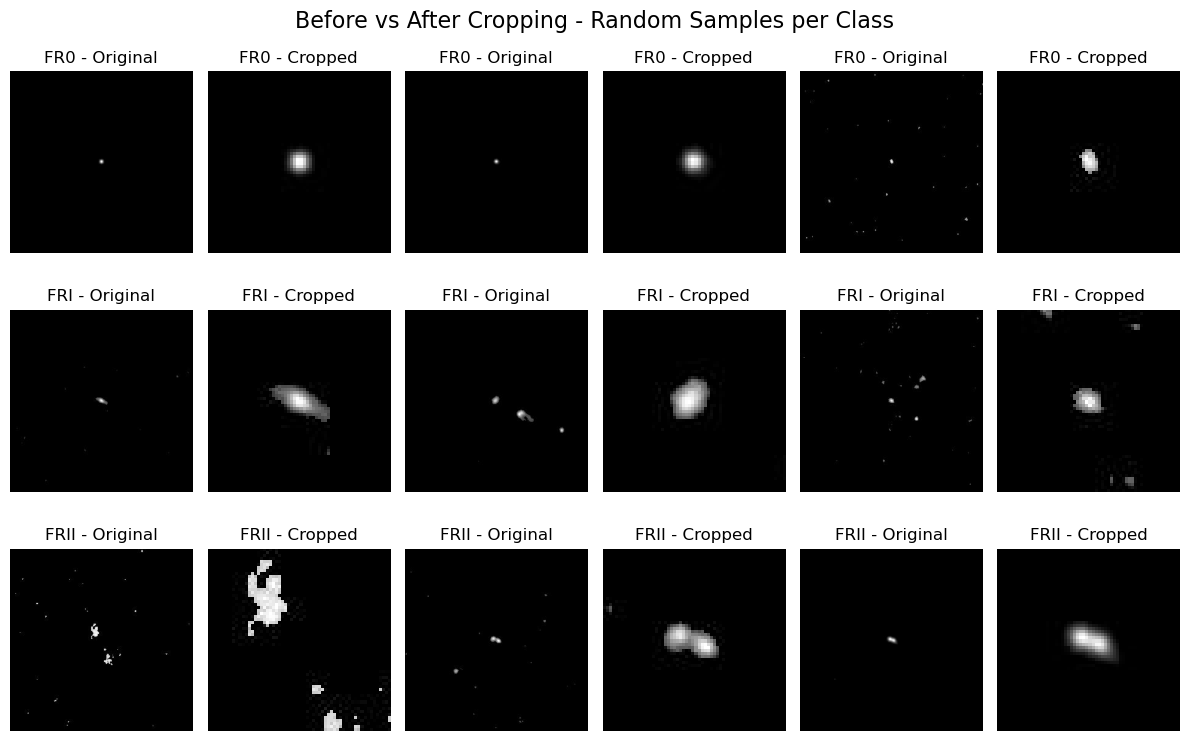

In [6]:
# 6.1 Sample Visualization (Before vs After Cropping)
def show_pre_post_cropping(full_images, cropped_images, image_labels, class_names, samples_per_class=3):
    num_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 4, num_classes * 2.5))

    for class_id in range(num_classes):
        # Find image indices for the current class
        class_indices = np.where(np.array(image_labels) == class_id)[0]
        
        if len(class_indices) < samples_per_class:
            continue  # skip if not enough samples
        
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        for i, idx in enumerate(selected_indices):
            # Original Image
            plt.subplot(num_classes, samples_per_class * 2, class_id * samples_per_class * 2 + i * 2 + 1)
            plt.imshow(full_images[idx], cmap='gray')
            plt.title(f"{class_names[class_id]} - Original")
            plt.axis('off')

            # Cropped Image
            plt.subplot(num_classes, samples_per_class * 2, class_id * samples_per_class * 2 + i * 2 + 2)
            plt.imshow(cropped_images[idx], cmap='gray')
            plt.title(f"{class_names[class_id]} - Cropped")
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Before vs After Cropping - Random Samples per Class", fontsize=16, y=1.02)
    plt.show()

# 🔁 Call function
show_pre_post_cropping(full_images, cropped_images, image_labels, class_names)


C:\Users\ZAIGHI\AppData\Local\Temp\ipykernel_18756\2163089255.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, palette="Set2")


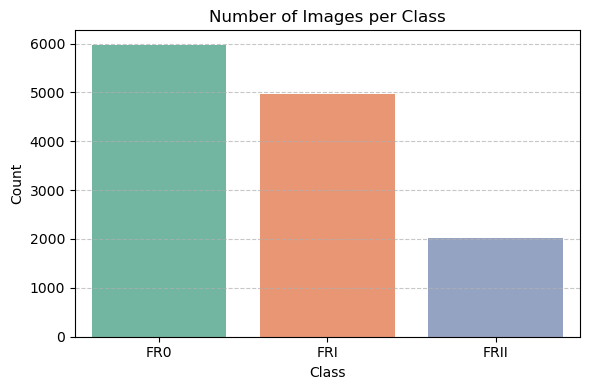

In [7]:
from collections import Counter

# Count filtered labels
label_counts = Counter(filtered_labels)
sorted_labels = sorted(label_counts.items())  # list of (label, count)

# Extract x (class indices) and y (counts)
x_vals = [item[0] for item in sorted_labels]
y_vals = [item[1] for item in sorted_labels]
x_labels = [class_names[i] for i in x_vals]  # safe mapping

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=x_vals, y=y_vals, palette="Set2")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=x_vals, labels=x_labels)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
# ----------------------------------
# 7. DATA AUGMENTATION FOR CLASS BALANCE
# ----------------------------------
# Use ImageDataGenerator to balance FRI and FRII classes
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

filtered_data = filtered_data[..., np.newaxis]  # Expand dims for augmentation

# Prepare containers
augmented_class_2 = []  # FRII
augmented_class_1 = []  # FRI

# Separate data
class_2_data = filtered_data[filtered_labels == 2]
class_1_data = filtered_data[filtered_labels == 1]

# Augment FRII
for _ in range(4000):
    img = class_2_data[np.random.randint(0, len(class_2_data))]
    aug_img = augmentor.random_transform(img)
    augmented_class_2.append(aug_img)

# Augment FRI
for _ in range(1000):
    img = class_1_data[np.random.randint(0, len(class_1_data))]
    aug_img = augmentor.random_transform(img)
    augmented_class_1.append(aug_img)

# Labels
augmented_labels_2 = [2] * len(augmented_class_2)
augmented_labels_1 = [1] * len(augmented_class_1)

print(f"Augmented: {len(augmented_class_1)} FRI, {len(augmented_class_2)} FRII")

Augmented: 1000 FRI, 4000 FRII


In [9]:
# 1. Convert augmented data to arrays
augmented_class_1 = np.array(augmented_class_1)
augmented_class_2 = np.array(augmented_class_2)
augmented_labels_1 = np.array(augmented_labels_1)
augmented_labels_2 = np.array(augmented_labels_2)

# 2. Merge original + augmented
final_images = np.concatenate([filtered_data, augmented_class_1, augmented_class_2], axis=0)
final_labels = np.concatenate([filtered_labels, augmented_labels_1, augmented_labels_2], axis=0)


C:\Users\ZAIGHI\AppData\Local\Temp\ipykernel_18756\1584061035.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=after_labels, y=after_values, palette=["#ff7f0e", "#f9a65a", "#fdd9b5"])


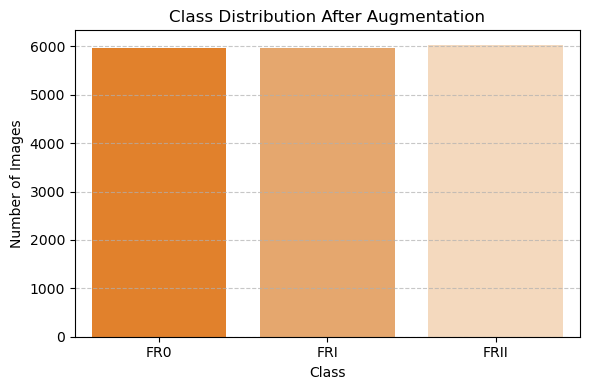

Final images shape: (17970, 60, 60, 1)
Final labels shape: (17970,)


In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Count class frequencies
after_counts = Counter(final_labels)
after_labels = list(after_counts.keys())
after_values = list(after_counts.values())
after_names = [class_names[i] for i in after_labels]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=after_labels, y=after_values, palette=["#ff7f0e", "#f9a65a", "#fdd9b5"])
plt.title("Class Distribution After Augmentation")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(after_labels, after_names)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Sanity check
print("Final images shape:", final_images.shape)
print("Final labels shape:", final_labels.shape)


In [11]:
# 8. COMBINE ORIGINAL AND AUGMENTED DATA
# ----------------------------------
# Merge filtered and augmented data into final dataset
final_images = np.concatenate([
    filtered_data,
    np.array(augmented_class_1),
    np.array(augmented_class_2)
], axis=0)

final_labels = np.concatenate([
    filtered_labels,
    np.array(augmented_labels_1),
    np.array(augmented_labels_2)
], axis=0)

print(f"Final dataset shape: {final_images.shape}, Labels: {final_labels.shape}")
print(f"Class distribution: {dict(Counter(final_labels))}")


Final dataset shape: (17970, 60, 60, 1), Labels: (17970,)
Class distribution: {0: 5972, 1: 5968, 2: 6030}


In [12]:
# 9. TRAIN-TEST SPLIT
# ----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    final_images, final_labels, test_size=0.2, stratify=final_labels, random_state=42
)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")


Training set: (14376, 60, 60, 1), Labels: (14376,)
Test set: (3594, 60, 60, 1), Labels: (3594,)


In [13]:
# 10. FEATURE EXTRACTION WITH RESNET50
# ----------------------------------
resnet_model = models.resnet50(weights='IMAGENET1K_V1')
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
resnet_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

transform_pipeline = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

X_train_features = []
for img in tqdm(X_train):
    img_t = transform_pipeline(img.squeeze())
    img_t = img_t.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = resnet_model(img_t).squeeze().cpu().numpy()
    X_train_features.append(feat)

X_test_features = []
for img in tqdm(X_test):
    img_t = transform_pipeline(img.squeeze())
    img_t = img_t.unsqueeze(0).to(device)
    with torch.no_grad():
        feat = resnet_model(img_t).squeeze().cpu().numpy()
    X_test_features.append(feat)

X_train_features = np.array(X_train_features)
X_test_features = np.array(X_test_features)

print("Feature extraction complete.")


100%|██████████████████████████████████████████████████████████████████████████████| 3594/3594 [00:54<00:00, 66.36it/s]

Feature extraction complete.


Shape of extracted feature vector: (2048,)
Sample of first 10 features:
 [0.10888775 0.0900598  0.31952623 0.08627767 0.21464768 0.11033313
 0.12381468 0.02956297 0.15832394 0.09600898]


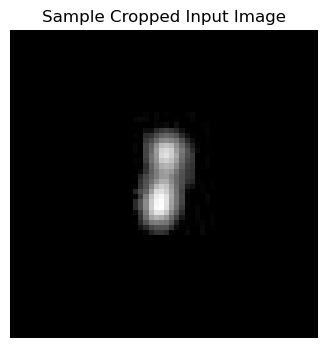

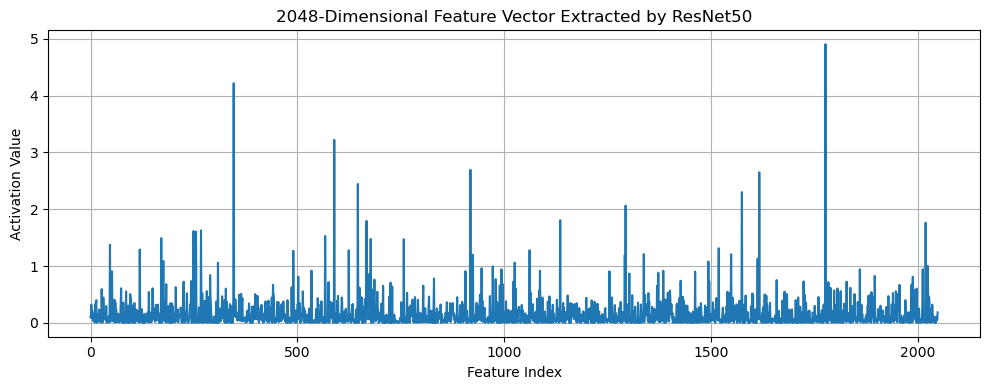

In [14]:
# Pick a sample image and its feature vector
sample_idx = 0
sample_image = X_train[sample_idx]
sample_feature_vector = X_train_features[sample_idx]

print(f"Shape of extracted feature vector: {sample_feature_vector.shape}")
print("Sample of first 10 features:\n", sample_feature_vector[:10])

# Display the input image
plt.figure(figsize=(5, 4))
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title("Sample Cropped Input Image")
plt.axis('off')
plt.show()

# Visualize the feature vector (compressed image representation)
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(len(sample_feature_vector)), y=sample_feature_vector)
plt.title("2048-Dimensional Feature Vector Extracted by ResNet50")
plt.xlabel("Feature Index")
plt.ylabel("Activation Value")
plt.grid(True)
plt.tight_layout()
plt.show()


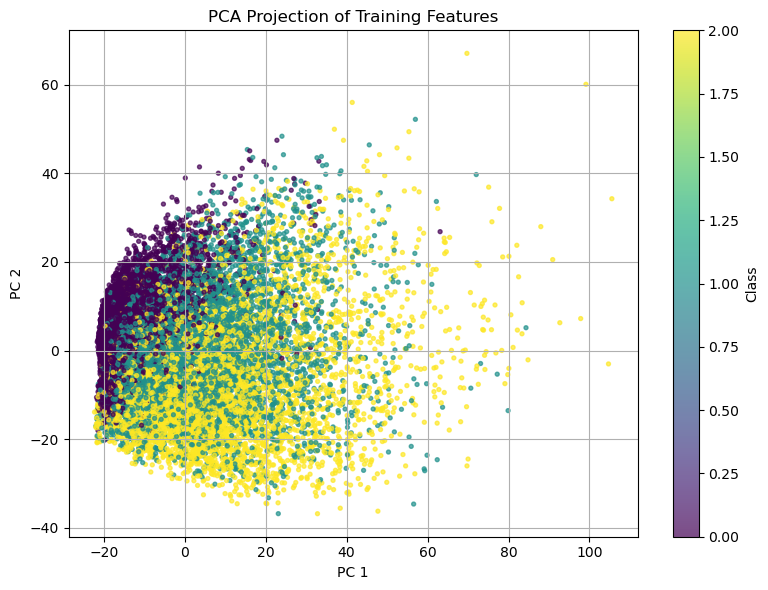

In [15]:
# ----------------------------------
# 11. DIMENSIONALITY REDUCTION (PCA)
# ----------------------------------
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# PCA to 50 components (retain structure)
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Visualize PCA projection (2D)
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, cmap='viridis', s=8, alpha=0.7)
plt.title("PCA Projection of Training Features")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Class')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
#PIXEL-LEVEL CORRELATION ANALYSIS FROM RAW IMAGES
# ----------------------------------
class_0_flatten = [img.flatten() for img, lbl in zip(final_images, final_labels) if lbl == 0]
class_1_flatten = [img.flatten() for img, lbl in zip(final_images, final_labels) if lbl == 1]
class_2_flatten = [img.flatten() for img, lbl in zip(final_images, final_labels) if lbl == 2]

class_0_flatten = np.array(class_0_flatten, dtype='uint8')
class_1_flatten = np.array(class_1_flatten, dtype='uint8')
class_2_flatten = np.array(class_2_flatten, dtype='uint8')

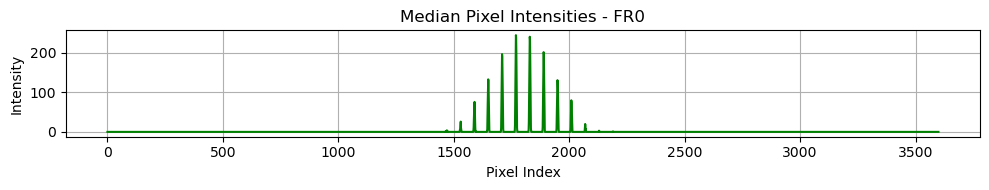

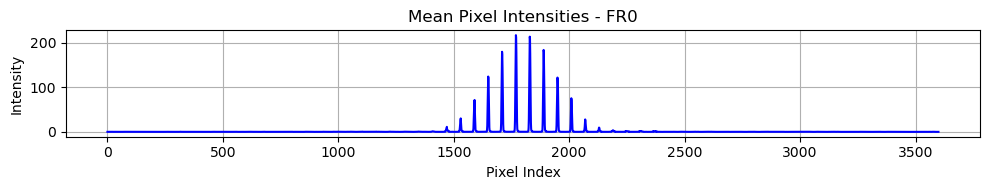

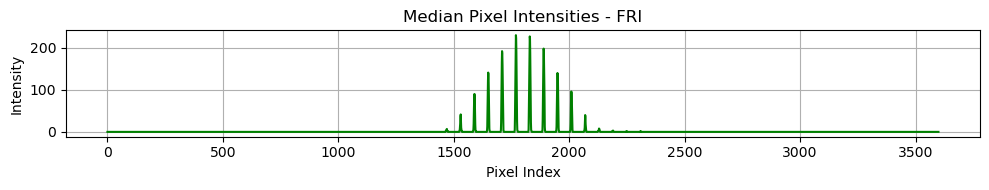

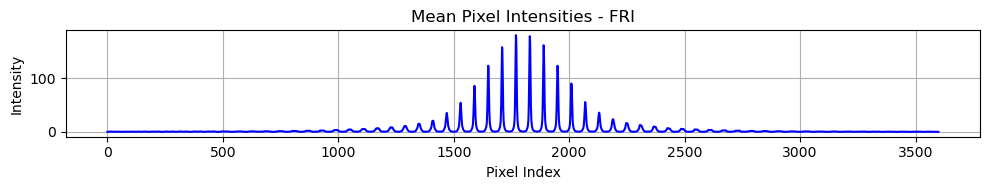

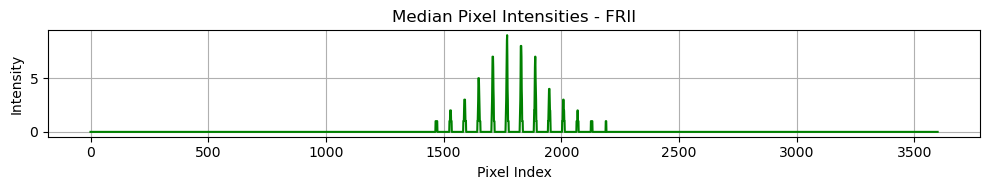

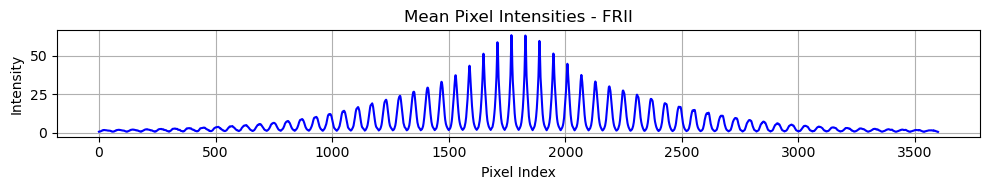

In [17]:
# Median and mean plots
for i, (data, name) in enumerate(zip(
    [class_0_flatten, class_1_flatten, class_2_flatten],
    ['FR0', 'FRI', 'FRII'])):

    plt.figure(figsize=(10, 2))
    plt.plot(np.median(data, axis=0), label=f"{name} Median", color='green')
    plt.title(f"Median Pixel Intensities - {name}")
    plt.xlabel("Pixel Index")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2))
    plt.plot(np.mean(data, axis=0), label=f"{name} Mean", color='blue')
    plt.title(f"Mean Pixel Intensities - {name}")
    plt.xlabel("Pixel Index")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

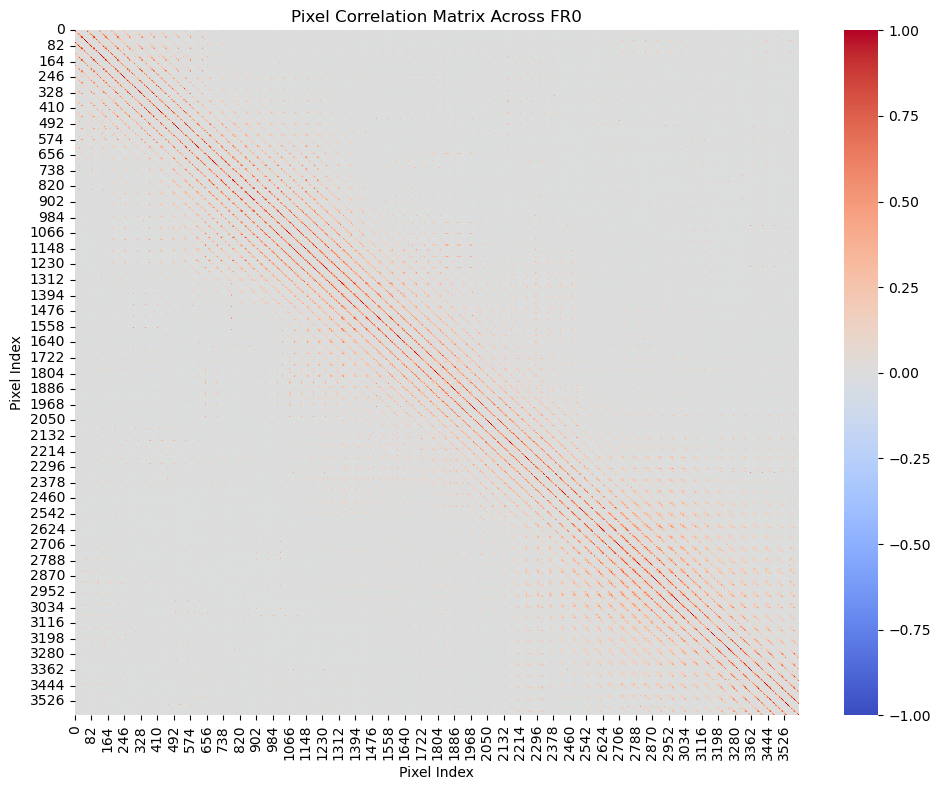

Pixel-wise correlation matrix and signal patterns visualized.


In [18]:
# Correlation matrix of FR0
correlation_matrix = np.corrcoef(class_0_flatten, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pixel Correlation Matrix Across FR0")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Index")
plt.tight_layout()
plt.show()

print("Pixel-wise correlation matrix and signal patterns visualized.")


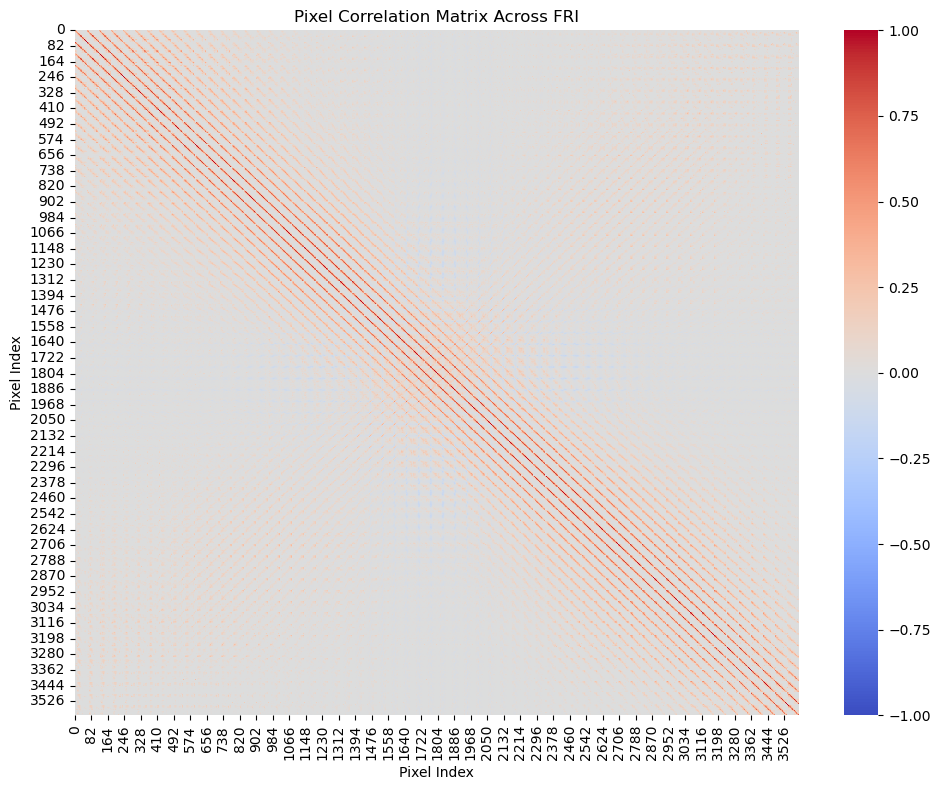

Pixel-wise correlation matrices and signal patterns visualized.


In [19]:
# Correlation matrix of FRI
correlation_matrix = np.corrcoef(class_1_flatten, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pixel Correlation Matrix Across FRI")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Index")
plt.tight_layout()
plt.show()

print("Pixel-wise correlation matrices and signal patterns visualized.")

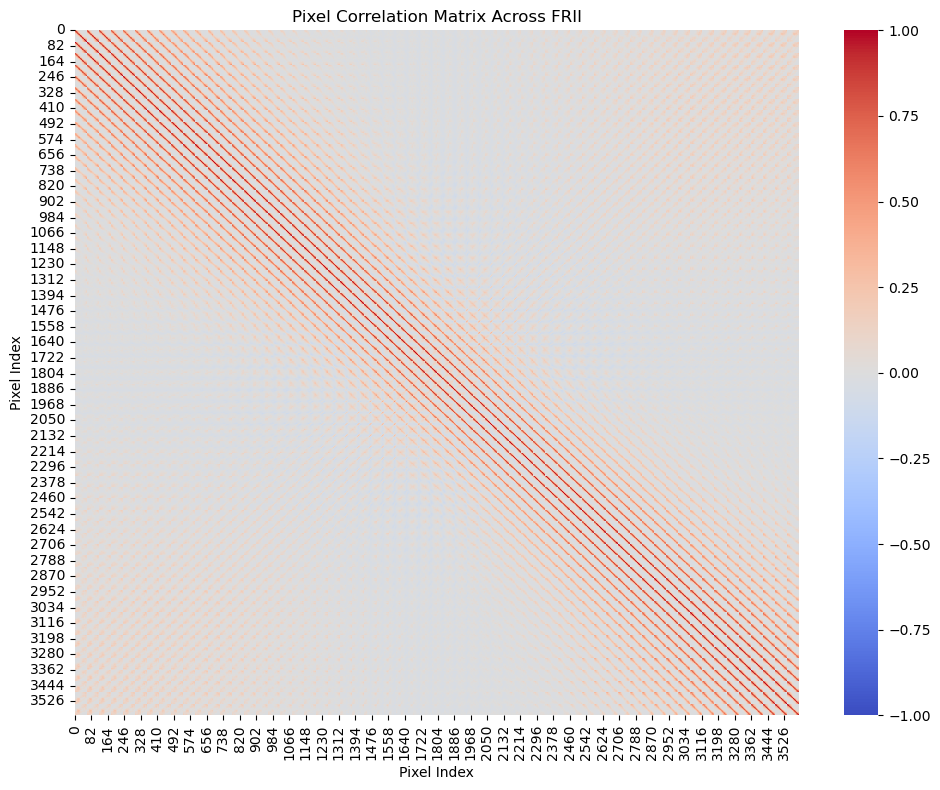

Pixel-wise correlation matrices and signal patterns visualized.


In [20]:
# Correlation matrix of FRII
correlation_matrix = np.corrcoef(class_2_flatten, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pixel Correlation Matrix Across FRII")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Index")
plt.tight_layout()
plt.show()

print("Pixel-wise correlation matrices and signal patterns visualized.")

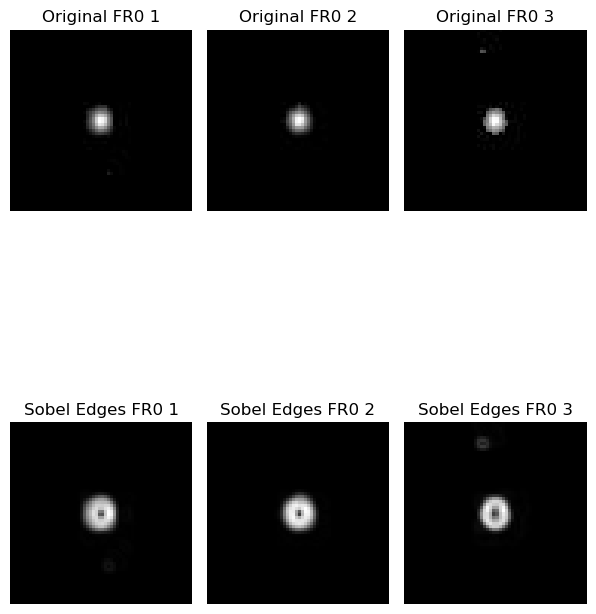

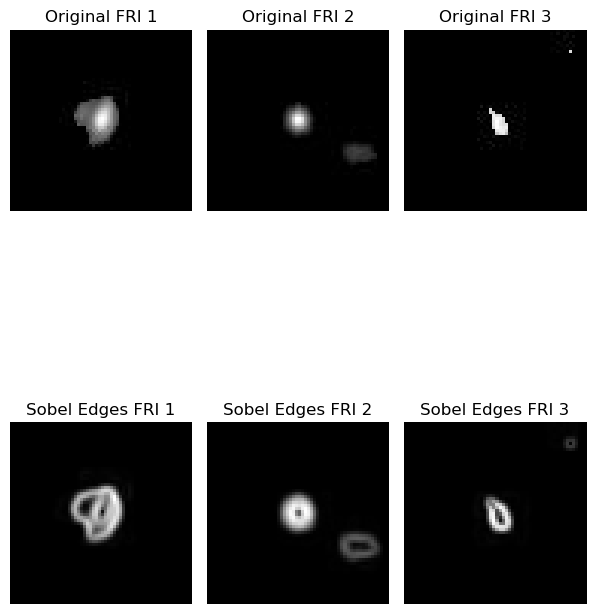

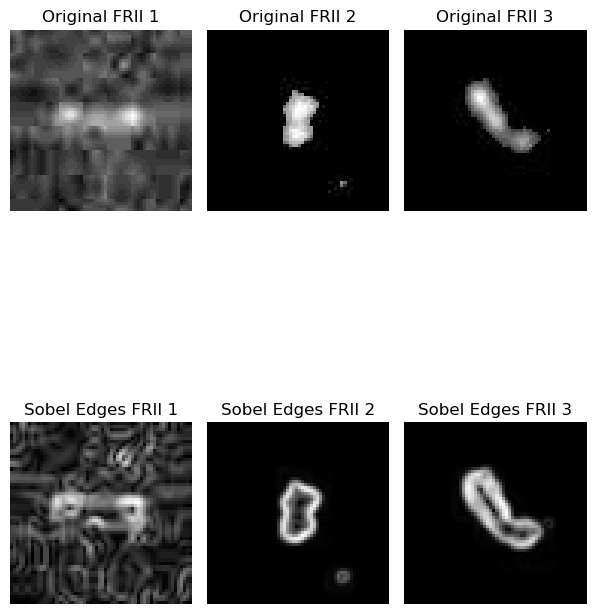

In [21]:
# ----------------------------------
# 12. EDGE DETECTION AND SYMMETRY ANALYSIS
# ----------------------------------
class_0_images = final_images[final_labels == 0]
class_1_images = final_images[final_labels == 1]
class_2_images = final_images[final_labels == 2]

# Sobel edge detection per class
for class_images, title in zip([class_0_images, class_1_images, class_2_images], ["FR0", "FRI", "FRII"]):
    plt.figure(figsize=(10, 8))
    for i in range(3):
        image = class_images[i]
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        edge_image = np.sqrt(sobel_x**2 + sobel_y**2)

        plt.subplot(2, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original {title} {i+1}")
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(edge_image, cmap='gray')
        plt.title(f"Sobel Edges {title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

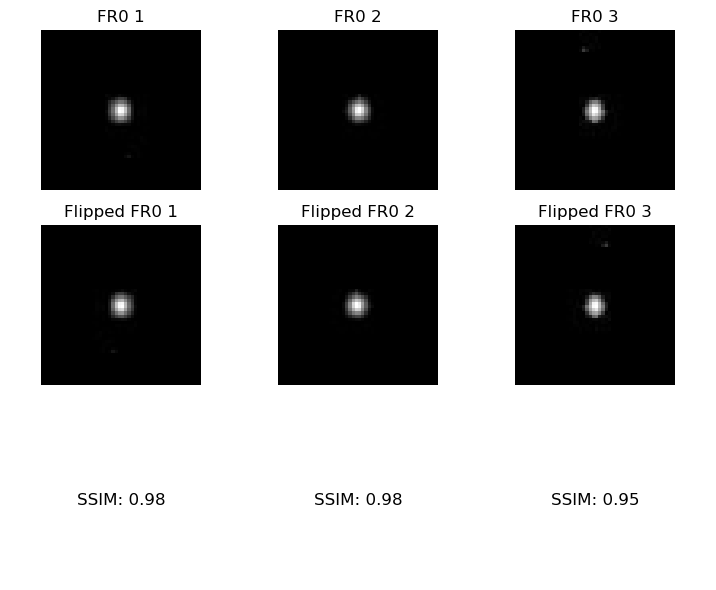

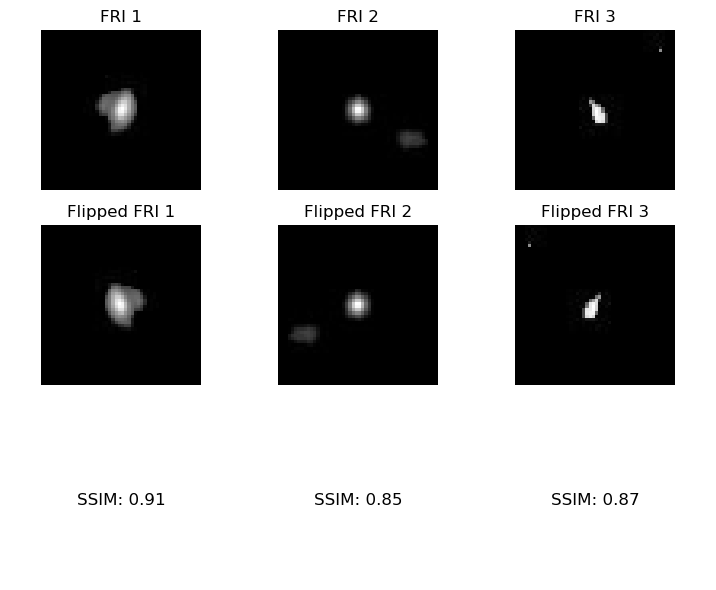

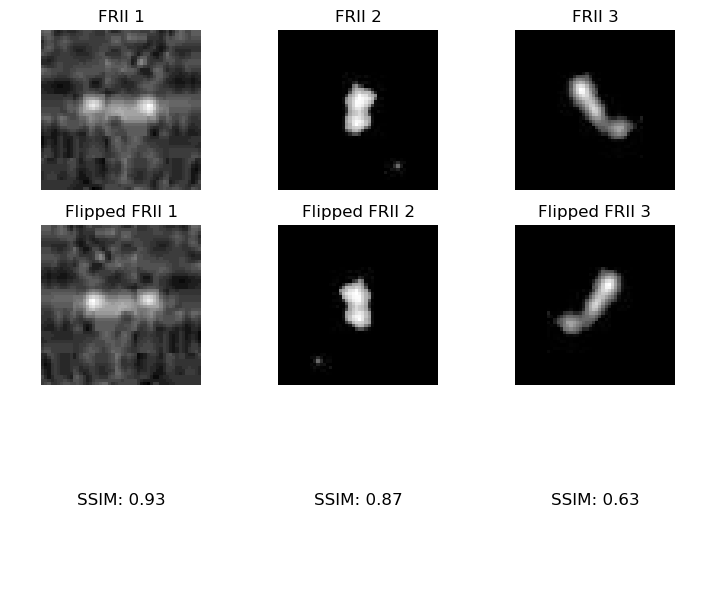

In [22]:
# Symmetry analysis via SSIM
for class_images, label in zip([class_0_images, class_1_images, class_2_images], ["FR0", "FRI", "FRII"]):
    plt.figure(figsize=(12, 6))
    for i in range(3):
        image = class_images[i]
        image = cv2.resize(image, (50, 50))
        flipped_image = cv2.flip(image, 1)
        symmetry_score, _ = ssim(image, flipped_image, full=True)

        plt.subplot(3, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{label} {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(flipped_image, cmap='gray')
        plt.title(f"Flipped {label} {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.text(0.5, 0.5, f"SSIM: {symmetry_score:.2f}", ha='center', va='center', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
# Compute average symmetry scores for each class
flipped_class_0_scores = [ssim(cv2.resize(i, (50, 50)), cv2.flip(cv2.resize(i, (50, 50)), 1), full=True)[0] for i in class_0_images]
flipped_class_1_scores = [ssim(cv2.resize(i, (50, 50)), cv2.flip(cv2.resize(i, (50, 50)), 1), full=True)[0] for i in class_1_images]
flipped_class_2_scores = [ssim(cv2.resize(i, (50, 50)), cv2.flip(cv2.resize(i, (50, 50)), 1), full=True)[0] for i in class_2_images]

flipped_class_0_scores = np.array(flipped_class_0_scores)
flipped_class_1_scores = np.array(flipped_class_1_scores)
flipped_class_2_scores = np.array(flipped_class_2_scores)

# Mean SSIM scores
flipped_class_0_scores_mean = np.mean(flipped_class_0_scores)
flipped_class_1_scores_mean = np.mean(flipped_class_1_scores)
flipped_class_2_scores_mean = np.mean(flipped_class_2_scores)
# Print results
print(f'FR0 images: {flipped_class_0_scores.shape}, FRI images: {flipped_class_1_scores.shape}, FRII images: {flipped_class_2_scores.shape}')
print(f'FR0 Symmetry Score: {flipped_class_0_scores_mean:.2f}, FRI Symmetry Score: {flipped_class_1_scores_mean:.2f}, FRII Symmetry Score: {flipped_class_2_scores_mean:.2f}')


FR0 images: (5972,), FRI images: (5968,), FRII images: (6030,)
FR0 Symmetry Score: 0.95, FRI Symmetry Score: 0.82, FRII Symmetry Score: 0.69


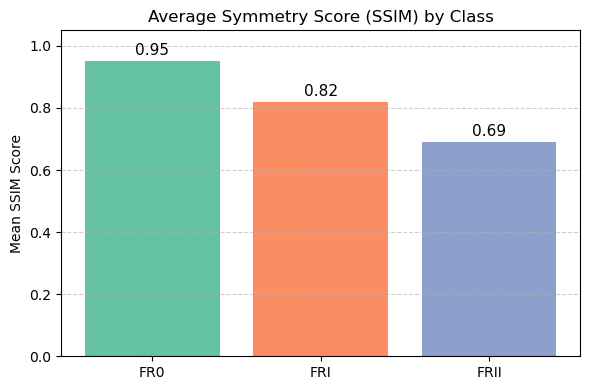

In [24]:
import matplotlib.pyplot as plt

# Mean SSIM values (from your results)
mean_ssim_scores = [0.95, 0.82, 0.69]
class_labels = ['FR0', 'FRI', 'FRII']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Distinct color palette

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(class_labels, mean_ssim_scores, color=colors)

# Annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=11)

plt.title("Average Symmetry Score (SSIM) by Class")
plt.ylabel("Mean SSIM Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [25]:
# Normalize data to [0, 1] range
final_images_normalized = final_images / 255.0
print(f"Original Min: {np.min(final_images[0])}, Max: {np.max(final_images[0])}")
print(f"Normalized Min: {np.min(final_images_normalized[0])}, Max: {np.max(final_images_normalized[0])}")

#Train-test split
x = final_images_normalized
y = final_labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


Original Min: 0, Max: 249
Normalized Min: 0.0, Max: 0.9764705882352941


In [26]:
# CNN Model Architecture
model_cnn = keras.Sequential()
tf.random.set_seed(42)  # for reproducibility

model_cnn.add(keras.layers.Conv2D(8, (3,3), input_shape=(60, 60, 1)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(16, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2)))

model_cnn.add(keras.layers.Conv2D(16, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(32, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPool2D((2, 2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(128, (3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Dense(3, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=9e-6)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model_cnn.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model_cnn.summary()

C:\Users\ZAIGHI\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 58, 58, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 58, 58, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 58, 58, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,9

 Total params: 147,251 (575.20 KB)

 Trainable params: 146,595 (572.64 KB)

 Non-trainable params: 656 (2.56 KB)

In [27]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (12579, 60, 60, 1)
y_train shape: (12579,)
x_test shape: (5391, 60, 60, 1)
y_test shape: (5391,)


In [28]:
# Class Weights (Optional override)
class_weight_dict = {0: 1.0, 1: 2.5, 2: 1.5}

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training
start = time.perf_counter()
history = model_cnn.fit(x_train, y_train, batch_size=512, epochs=200,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping])
end = time.perf_counter()
print(f"Training time: {end - start:.2f} seconds")


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - accuracy: 0.3705 - loss: 2.2714 - val_accuracy: 0.3317 - val_loss: 1.0998
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 575ms/step - accuracy: 0.4313 - loss: 2.0932 - val_accuracy: 0.3317 - val_loss: 1.1036
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.4867 - loss: 1.9198 - val_accuracy: 0.3317 - val_loss: 1.1092
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.5274 - loss: 1.8185 - val_accuracy: 0.3317 - val_loss: 1.1145
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 577ms/step - accuracy: 0.5559 - loss: 1.7312 - val_accuracy: 0.3317 - val_loss: 1.1195
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.5786 - loss: 1.6737 - val_accuracy: 0.3317 - val_loss: 1.1234
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 512ms/step - accuracy: 0.5874 - loss: 1.6086 - val_accuracy: 0.3317 - val_loss: 1.1238
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 513ms/step - accuracy: 0.6115 - loss: 1.5546 - 

In [39]:
# Save the model in the recommended .keras format
model_cnn.save('cnn_model.keras')  # Save the model in .keras format


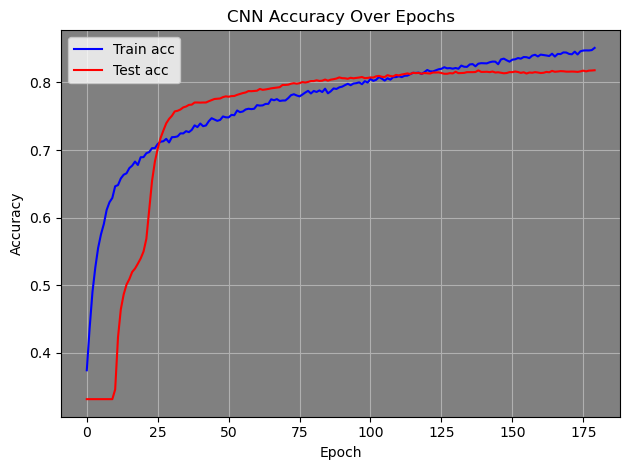

In [30]:
# Accuracy plot (alternative style)
acc_train = history.history['accuracy']
acc_test = history.history['val_accuracy']

plt.axes().set_facecolor('gray')
plt.grid(True)
plt.plot(acc_train, color='blue', label='Train acc')
plt.plot(acc_test, color='red', label='Test acc')
plt.title("CNN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


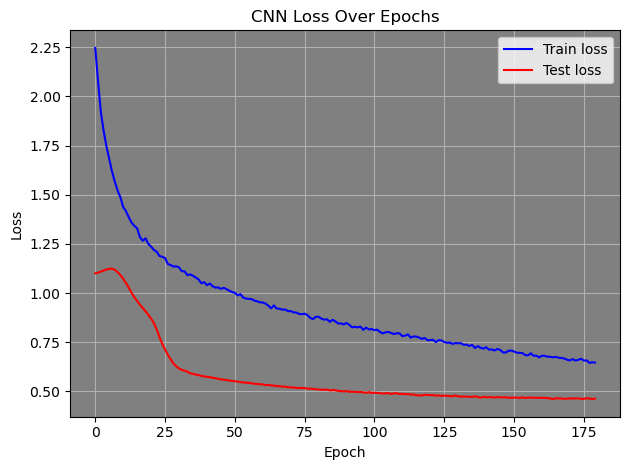

In [31]:
# Loss plot (alternative style)
loss_train = history.history['loss']
loss_test = history.history['val_loss']

plt.axes().set_facecolor('gray')
plt.grid(True)
plt.plot(loss_train, color='blue', label='Train loss')
plt.plot(loss_test, color='red', label='Test loss')
plt.title("CNN Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
# Evaluation
model_cnn.evaluate(x_test, y_test)
model_cnn.evaluate(x_train, y_train)

# Predictions
y_pred_train = model_cnn.predict(x_train)
y_pred_test = model_cnn.predict(x_test)

# Softmax → argmax
y_pred_train_smax = np.argmax(y_pred_train, axis=1)
y_pred_test_smax = np.argmax(y_pred_test, axis=1)

# Metrics
acc_train = accuracy_score(y_train, y_pred_train_smax)
acc_test = accuracy_score(y_test, y_pred_test_smax)

p = precision_score(y_test, y_pred_test_smax, average='micro')
r = recall_score(y_test, y_pred_test_smax, average='micro')
f1 = f1_score(y_test, y_pred_test_smax, average='micro')

print(f"Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}, Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}")


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8157 - loss: 0.4612
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8660 - loss: 0.3560
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Train Accuracy: 0.8660, Test Accuracy: 0.8171, Precision: 0.8171, Recall: 0.8171, F1: 0.8171


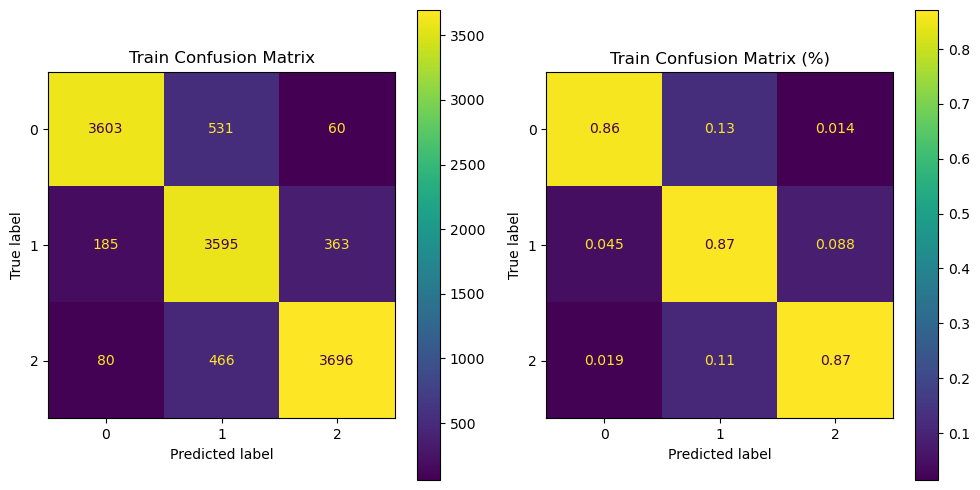

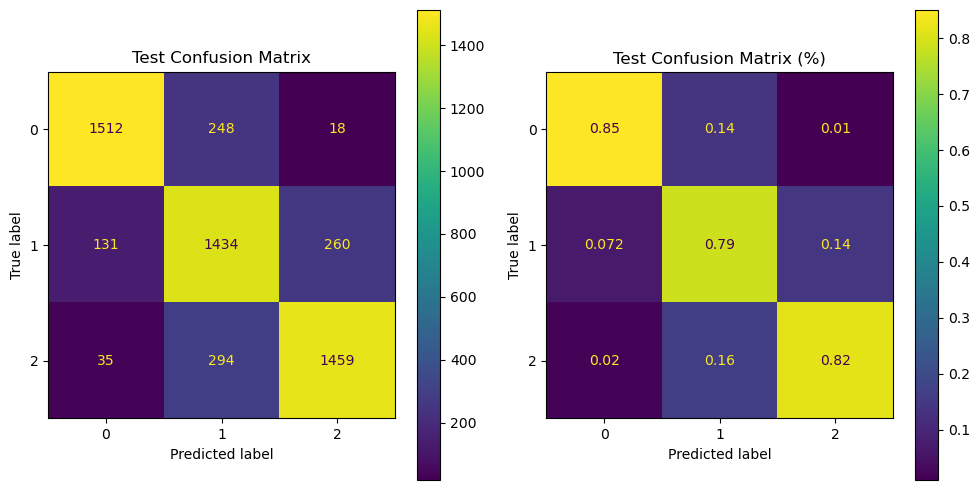

In [33]:
# Confusion Matrices
cm_train = confusion_matrix(y_train, y_pred_train_smax)
cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(y_test, y_pred_test_smax)
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(cm_train).plot(ax=ax1)
ax1.set_title("Train Confusion Matrix")
ConfusionMatrixDisplay(cm_train_norm).plot(ax=ax2)
ax2.set_title("Train Confusion Matrix (%)")
plt.tight_layout()
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(cm_test).plot(ax=ax3)
ax3.set_title("Test Confusion Matrix")
ConfusionMatrixDisplay(cm_test_norm).plot(ax=ax4)
ax4.set_title("Test Confusion Matrix (%)")
plt.tight_layout()
plt.show()

In [34]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


C:\Users\ZAIGHI\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\ZAIGHI\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 60, 60, 1))']
  warnings.warn(msg)
C:\Users\ZAIGHI\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 60, 60, 1))']
  warnings.warn(msg)
C:\Users\ZAIGHI\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(

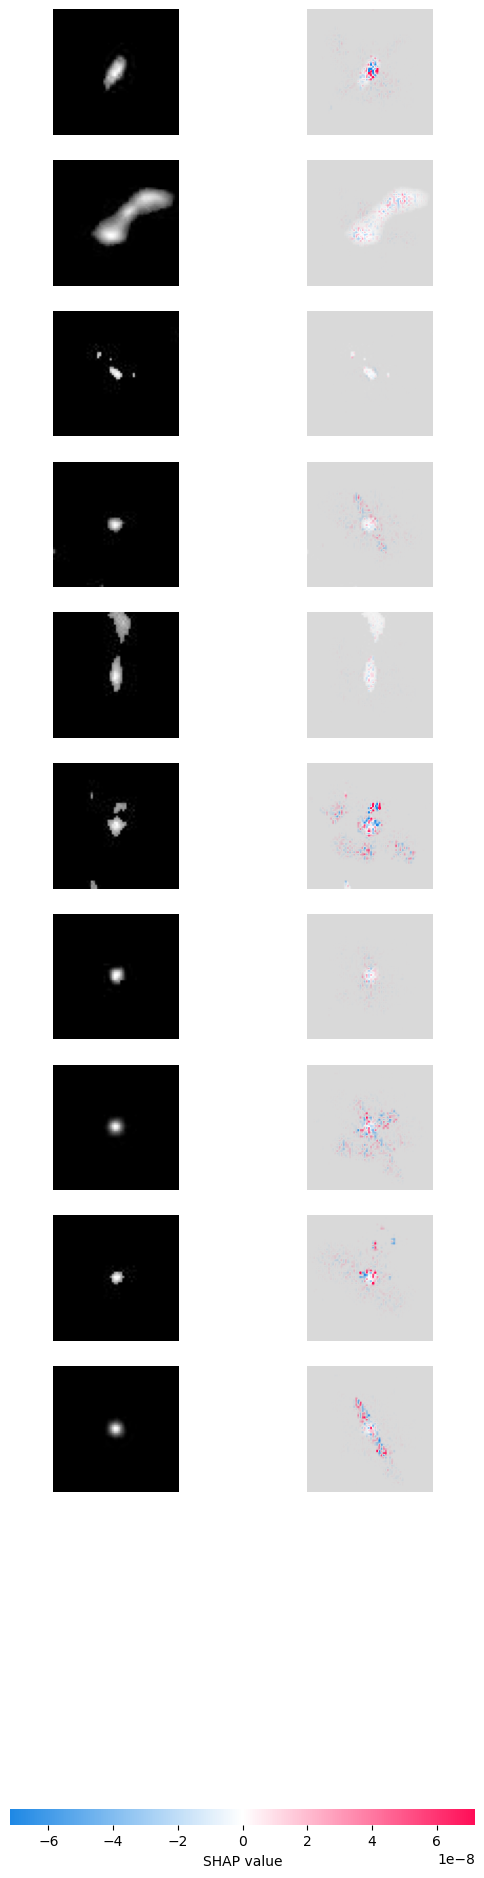

In [35]:

explainer = shap.DeepExplainer(model_cnn, x_train[:100])
shap_values = explainer.shap_values(x_test[:10])

shap.image_plot(shap_values, x_test[:10])


In [36]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


C:\Users\ZAIGHI\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:24:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 0.8093
Classification Report:

              precision    recall  f1-score   support

         FR0       0.86      0.91      0.88      1778
         FRI       0.77      0.67      0.72      1825
        FRII       0.79      0.86      0.82      1788

    accuracy                           0.81      5391
   macro avg       0.81      0.81      0.81      5391
weighted avg       0.81      0.81      0.81      5391



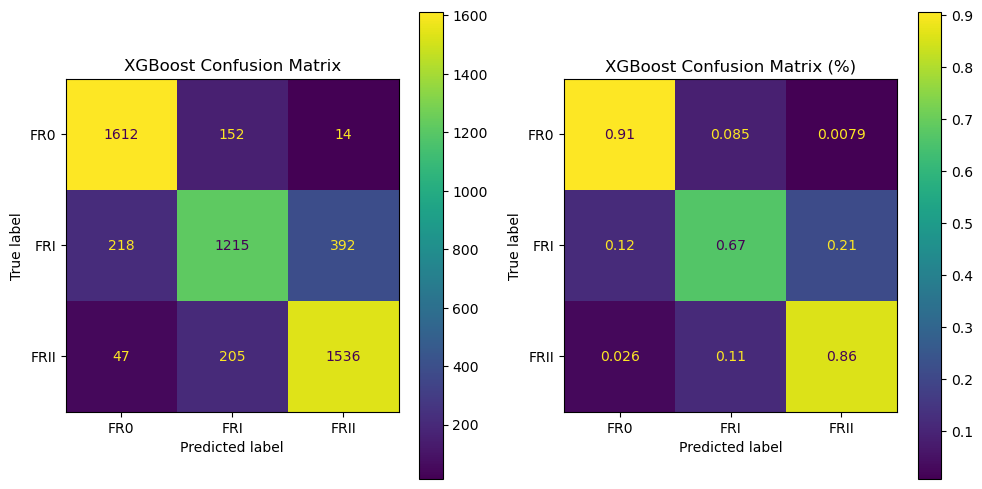

In [37]:
# Flatten normalized image data for XGBoost input
X_flat = final_images_normalized.reshape((final_images_normalized.shape[0], -1))
y = final_labels

# Split for training and testing
X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_flat, y, test_size=0.3, random_state=42)

# Train XGBoost Model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train_flat, y_train_flat)

# Predict
y_pred_xgb = xgb_model.predict(X_test_flat)

# Evaluation
acc_xgb = accuracy_score(y_test_flat, y_pred_xgb)
print(f"XGBoost Test Accuracy: {acc_xgb:.4f}")

print("Classification Report:\n")
print(classification_report(y_test_flat, y_pred_xgb, target_names=['FR0', 'FRI', 'FRII']))

# Confusion Matrix Visualization
cm_xgb = confusion_matrix(y_test_flat, y_pred_xgb)
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['FR0', 'FRI', 'FRII']).plot(ax=ax1)
ax1.set_title("XGBoost Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix=cm_xgb_norm, display_labels=['FR0', 'FRI', 'FRII']).plot(ax=ax2)
ax2.set_title("XGBoost Confusion Matrix (%)")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


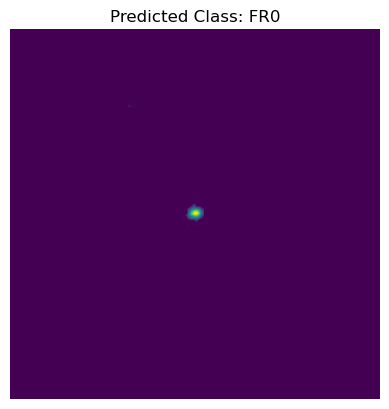

Predicted class: FR0
Model's prediction probabilities: [[0.7321779 0.1539564 0.1138657]]


In [43]:
# Load the model
model = tf.keras.models.load_model('cnn_model.keras')

# Define the class names (adjust accordingly based on your dataset)
class_names = ['FR0', 'FRI', 'FRII']

def prepare_image(img_path):
    """Preprocess the image for prediction."""
    # Load the image
    img = Image.open(img_path).convert("L")  # Convert to grayscale
    img_resized = img.resize((60, 60))  # Resize to (60, 60)
    
    # Convert image to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=-1)  # Make it (60, 60, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Make it (1, 60, 60, 1)
    
    return img_array

def classify_image(img_path):
    """Classify an image and output the class prediction."""
    # Prepare the image
    prepared_img = prepare_image(img_path)
    
    # Predict using the model
    predictions = model.predict(prepared_img)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get class index with highest probability
    
    # Display the image and the prediction
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()
    
    return class_names[predicted_class], predictions

# Path to the image you want to classify
image_path = r'C:\Users\ZAIGHI\Downloads\Compressed\radio_morphology_project\J172159.27+573535.1.jpg'

# Classify the image
predicted_class, predictions = classify_image(image_path)

print(f"Predicted class: {predicted_class}")
print(f"Model's prediction probabilities: {predictions}")
